# Playground

This jupiter servers the purporse of practicing. It check the dataset and each layer to gather some informations

In [1]:
import torch

if torch.cuda.is_available():
    print("CUDA is available. PyTorch can use the GPUs.")
    num_gpus = torch.cuda.device_count()
    print(f"Number of GPUs available: {num_gpus}")
    for i in range(num_gpus):
        print(f"  GPU {i}: {torch.cuda.get_device_name(i)}")
    if num_gpus > 1:
        print("\nBoth GPUs can be used for training.")
        print("To leverage both GPUs, you can use torch.nn.DataParallel to wrap your model.")
else:
    print("CUDA is not available. PyTorch will use the CPU.")

CUDA is available. PyTorch can use the GPUs.
Number of GPUs available: 2
  GPU 0: NVIDIA GeForce RTX 5060 Ti
  GPU 1: NVIDIA GeForce RTX 5060 Ti

Both GPUs can be used for training.
To leverage both GPUs, you can use torch.nn.DataParallel to wrap your model.


In [17]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt
import random
import cv2

# File counts

In [3]:
dataset_path = '../dataset'

scenes = [scene for scene in os.listdir(dataset_path) if os.path.isdir(os.path.join(dataset_path, scene))]
scenes.sort()

file_counts = {scene: len(os.listdir(os.path.join(dataset_path, scene))) for scene in scenes}

print("File counts per scene:")
for scene, count in file_counts.items():
    print(f"- {scene}: {count} files")

File counts per scene:
- scene1: 864 files
- scene2: 594 files
- scene3: 504 files
- scene4: 504 files


# Code Structure

In [6]:
scene1_path = os.path.join(dataset_path, 'scene1')

try:
    first_file_name = os.listdir(scene1_path)[0]
    file_to_inspect = os.path.join(scene1_path, first_file_name)
    
    print(f"Inspecting file: {file_to_inspect}")

    with np.load(file_to_inspect) as data:
        available_keys = data.files
        print(f"Available keys in the .npz file: {available_keys}")

        if available_keys:
            first_key = available_keys[0]
            print(f"Shape of the array with key '{first_key}': {data[first_key].shape}")

except IndexError:
    print(f"Error: No files found in {scene1_path}. Please check the directory.")
except FileNotFoundError:
    print(f"Error: The directory {scene1_path} was not found. Please check the path.")

Inspecting file: ../dataset\scene1\scene_1_patch_10_1.npz
Available keys in the .npz file: ['image', 'aerosol', 'label']
Shape of the array with key 'image': (12, 512, 512)


# Label distribution

Analyzing scene4: 100%|██████████| 504/504 [00:03<00:00, 166.90it/s]


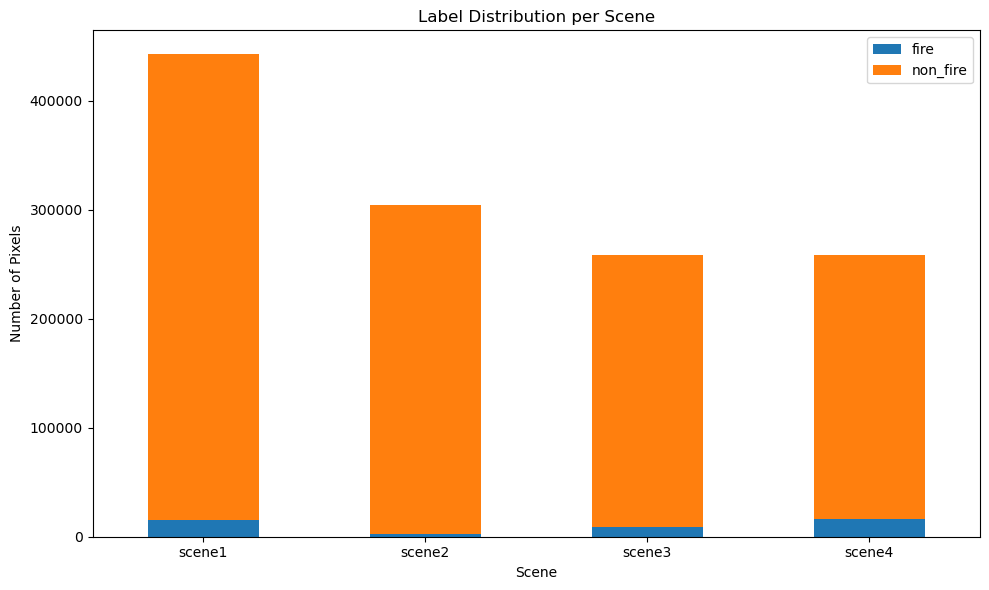

In [7]:
label_distribution = {}

for scene in scenes:
    scene_path = os.path.join(dataset_path, scene)
    fire_pixels = 0
    non_fire_pixels = 0
    
    for filename in tqdm(os.listdir(scene_path), desc=f"Analyzing {scene}"):
        filepath = os.path.join(scene_path, filename)
        with np.load(filepath) as data:
            labels = data['label'][-1]
            fire_pixels += np.sum(labels == 1)
            non_fire_pixels += np.sum(labels == 0)
            
    label_distribution[scene] = {'fire': fire_pixels, 'non_fire': non_fire_pixels}

df_labels = pd.DataFrame(label_distribution).T

df_labels.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title('Label Distribution per Scene')
plt.xlabel('Scene')
plt.ylabel('Number of Pixels')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# Layer-label correlatin

Loading sampled training data: 100%|██████████| 40/40 [00:26<00:00,  1.54it/s]



Sampled 10485760 pixels from the training set for correlation analysis.


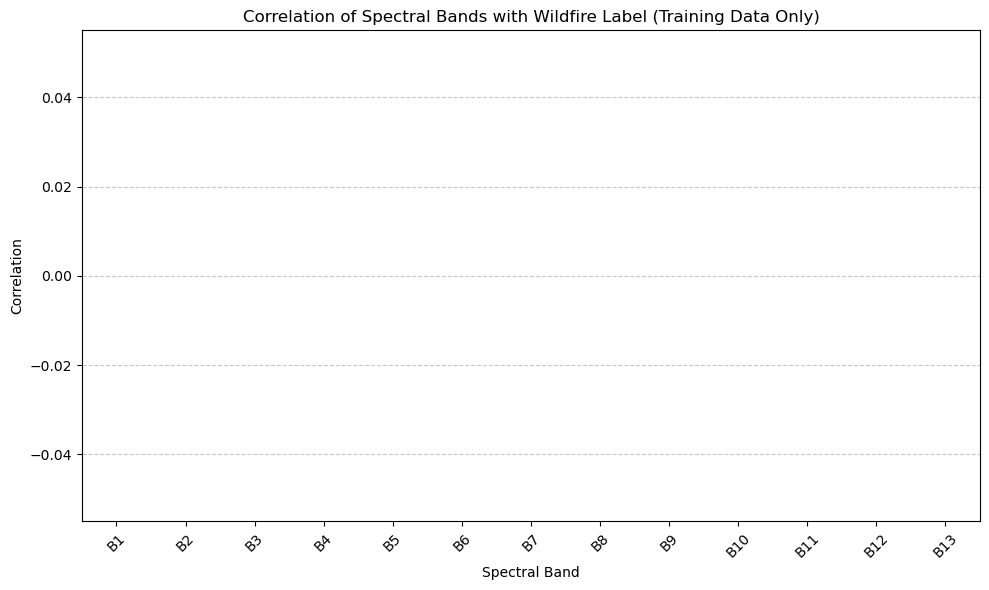


Correlation with label (based on training data):
B1    NaN
B2    NaN
B3    NaN
B4    NaN
B5    NaN
B6    NaN
B7    NaN
B8    NaN
B9    NaN
B10   NaN
B11   NaN
B12   NaN
B13   NaN
Name: label, dtype: float64


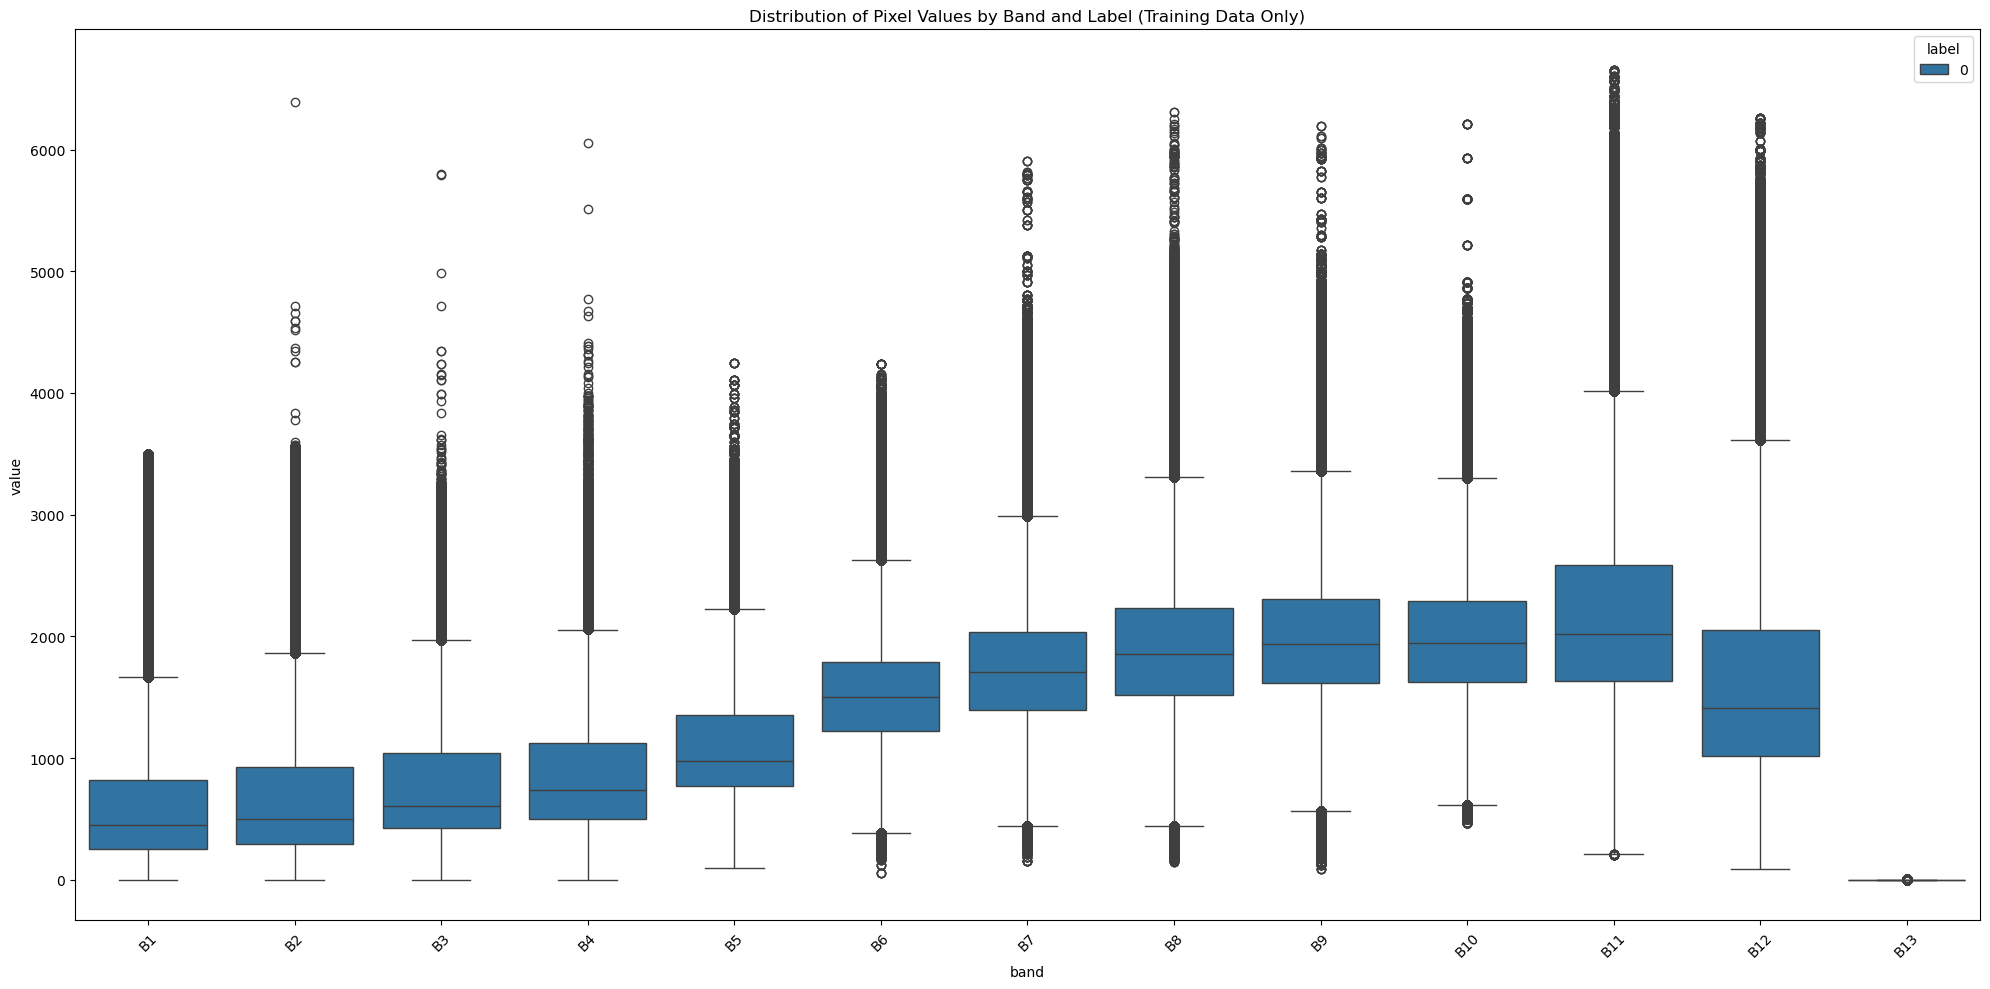

In [11]:
# Define the scenes designated for training
training_scenes = ['scene1', 'scene2']

# Sample files ONLY from the training scenes
sample_files = []
# To get a good sample size from the training data, we'll take 20 files from each training scene
num_samples_per_scene = 20

for scene in tqdm(training_scenes, desc="Sampling training files"):
    scene_path = os.path.join(dataset_path, scene)
    files = os.listdir(scene_path)
    
    # Ensure we don't try to sample more files than are available
    sample_count = min(num_samples_per_scene, len(files))
    
    sample_files.extend([os.path.join(scene_path, f) for f in np.random.choice(files, sample_count, replace=False)])

# --- The rest of the data loading and processing is the same ---
data_list = []

for f in tqdm(sample_files, desc="Loading sampled training data"):
    with np.load(f) as data:
        image_layers = data['image']
        aerosol_layer = data['aerosol']
        label_layer = data['label']

        flat_image_layers = [layer.flatten() for layer in image_layers]
        flat_aerosol_layer = aerosol_layer.flatten()
        flat_label_layer = label_layer.flatten()
        
        num_pixels = len(flat_label_layer)

        for i in range(num_pixels):
            row = {}
            for j in range(12):
                row[f'B{j+1}'] = flat_image_layers[j][i]
            row['B13'] = flat_aerosol_layer[i]
            row['label'] = flat_label_layer[i]
            data_list.append(row)

# Create a DataFrame from the training data sample
df_corr = pd.DataFrame(data_list)

print(f"\nSampled {len(df_corr)} pixels from the training set for correlation analysis.")

# Calculate the correlation matrix
correlation_matrix = df_corr.corr()

# Get the correlation with the 'label' column
label_correlation = correlation_matrix['label'].drop('label')

# Plot the correlation
plt.figure(figsize=(10, 6))
sns.barplot(x=label_correlation.index, y=label_correlation.values)
plt.title('Correlation of Spectral Bands with Wildfire Label (Training Data Only)')
plt.xlabel('Spectral Band')
plt.ylabel('Correlation')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

print("\nCorrelation with label (based on training data):")
print(label_correlation)

# Create boxplots to visualize distributions on the training data
df_melted = df_corr.melt(id_vars='label', var_name='band', value_name='value')

plt.figure(figsize=(20, 10))
sns.boxplot(x='band', y='value', hue='label', data=df_melted)
plt.title('Distribution of Pixel Values by Band and Label (Training Data Only)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Check augmentation

Loading random patch for augmentation test: ../dataset\scene2\scene_2_patch_18_6.npz


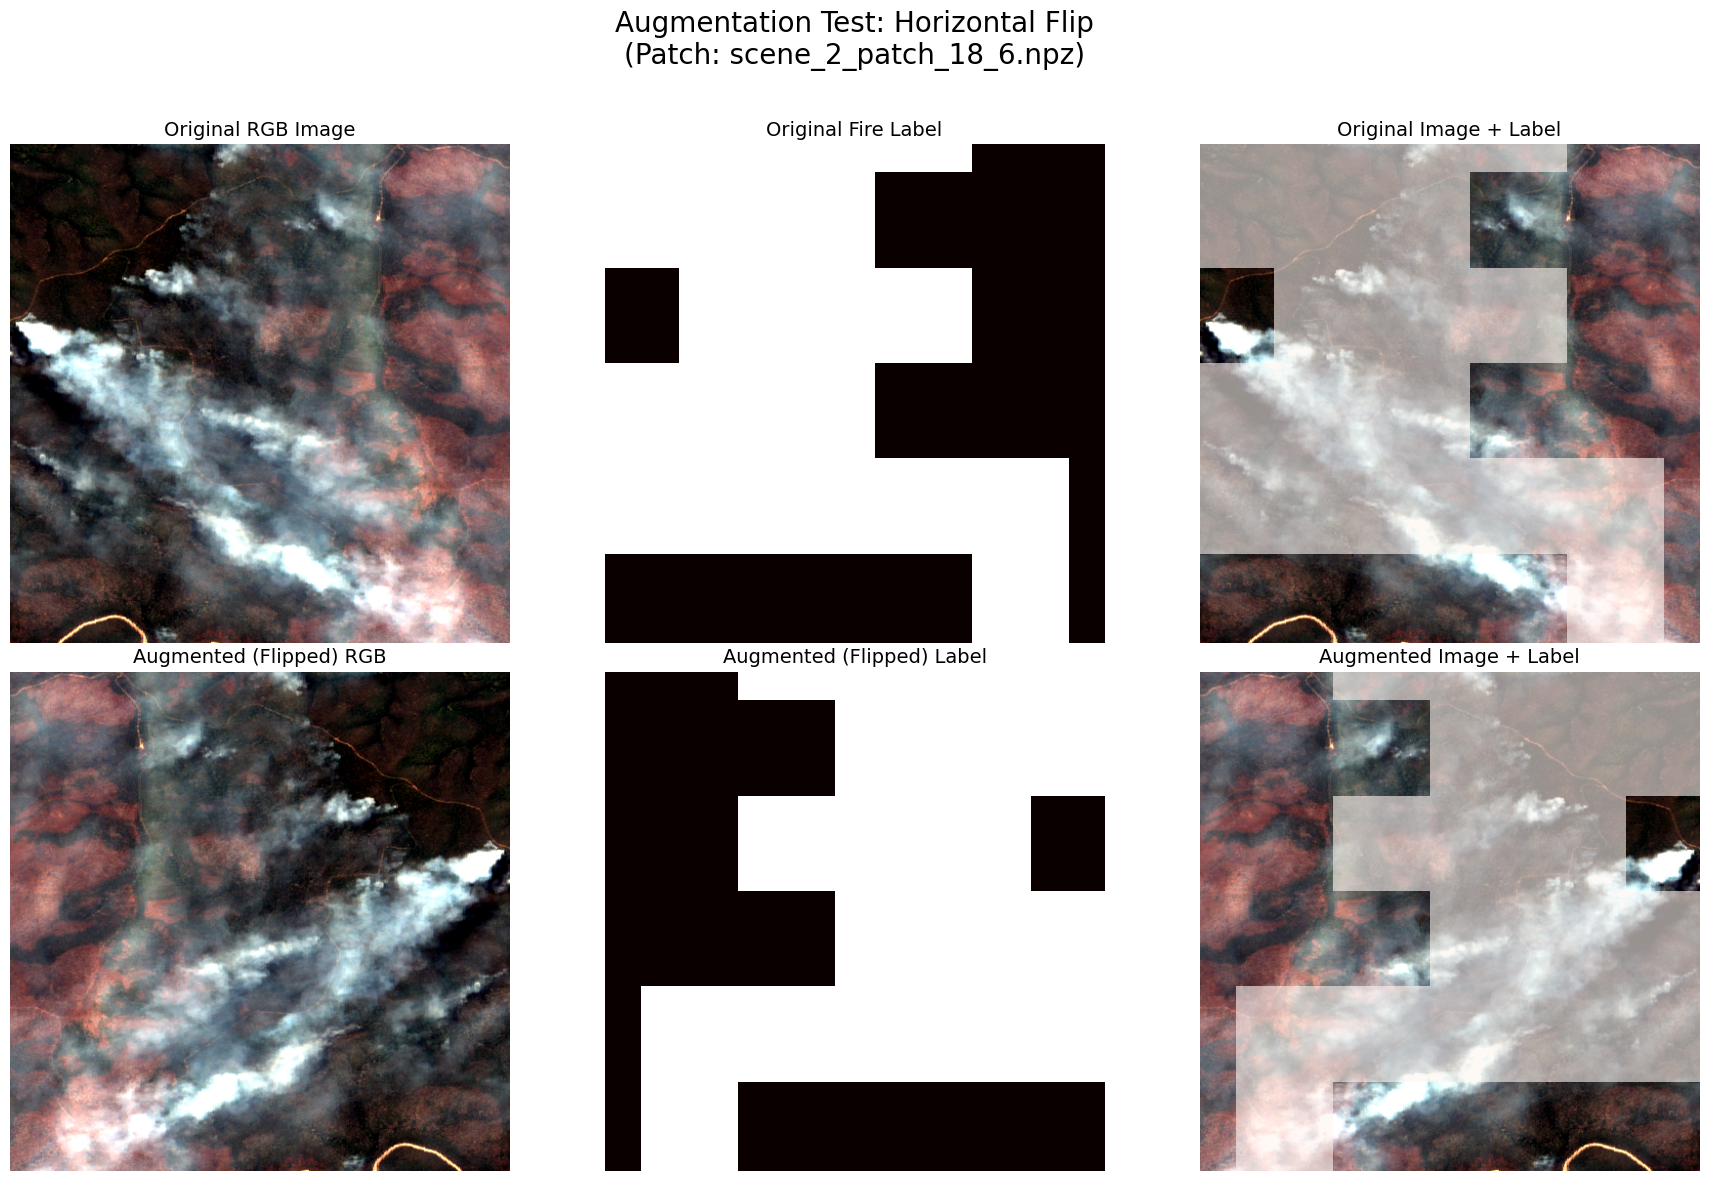

In [15]:
# Select a random scene from the training set
random_scene = random.choice(training_scenes)
scene_path = os.path.join(dataset_path, random_scene)

# Select a random image patch from that scene
random_patch_name = random.choice(os.listdir(scene_path))
patch_path = os.path.join(scene_path, random_patch_name)

print(f"Loading random patch for augmentation test: {patch_path}")

# --- 2. Load and Prepare Data ---

with np.load(patch_path) as data:
    # The 'image' array contains the 12 spectral bands (shape: 12, 512, 512)
    image_bands = data['image']
    # The 'label' array is the fire mask (shape: 512, 512)
    fire_label = data['label']

# Extract the bands for RGB visualization as per the paper
# B4 (Red) is at index 3
# B3 (Green) is at index 2
# B2 (Blue) is at index 1
red_band = image_bands[3, :, :]
green_band = image_bands[2, :, :]
blue_band = image_bands[1, :, :]

# Stack the bands to create an RGB image for plotting
# The shape needs to be (height, width, channels) for matplotlib
original_rgb = np.stack([red_band, green_band, blue_band], axis=-1)

# --- 3. Normalize for Visualization ---
# A simple way to normalize for visualization is to clip to the 2nd and 98th percentiles
# to handle extreme outliers and then scale to the 0-1 range.
def normalize_for_display(rgb_image):
    rgb_normalized = rgb_image.copy().astype(float)
    for i in range(3):
        p2, p98 = np.percentile(rgb_normalized[:, :, i], (2, 98))
        rgb_normalized[:, :, i] = np.clip(rgb_normalized[:, :, i], p2, p98)
        rgb_normalized[:, :, i] = (rgb_normalized[:, :, i] - p2) / (p98 - p2)
    return rgb_normalized

original_rgb_display = normalize_for_display(original_rgb)

# --- 4. Perform Augmentation (Horizontal Flip) ---

# Use np.fliplr() to flip the arrays horizontally
augmented_rgb_display = np.fliplr(original_rgb_display)
augmented_label = np.fliplr(fire_label)


# --- 5. Plotting ---

# Create a 2x3 subplot grid
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle(f'Augmentation Test: Horizontal Flip\n(Patch: {random_patch_name})', fontsize=20)

# --- Row 1: Original Data ---

# Column 1: Original RGB
axes[0, 0].imshow(original_rgb_display)
axes[0, 0].set_title('Original RGB Image', fontsize=14)
axes[0, 0].axis('off')

# Column 2: Original Fire Label
axes[0, 1].imshow(fire_label, cmap='hot', interpolation='nearest')
axes[0, 1].set_title('Original Fire Label', fontsize=14)
axes[0, 1].axis('off')

# Column 3: Original RGB with Label Overlay
# To overlay, we create a masked version of the label where 0s are transparent
masked_label = np.ma.masked_where(fire_label == 0, fire_label)
axes[0, 2].imshow(original_rgb_display)
axes[0, 2].imshow(masked_label, cmap='Reds', alpha=0.6, interpolation='nearest')
axes[0, 2].set_title('Original Image + Label', fontsize=14)
axes[0, 2].axis('off')


# --- Row 2: Augmented Data ---

# Column 1: Augmented RGB
axes[1, 0].imshow(augmented_rgb_display)
axes[1, 0].set_title('Augmented (Flipped) RGB', fontsize=14)
axes[1, 0].axis('off')

# Column 2: Augmented Fire Label
axes[1, 1].imshow(augmented_label, cmap='hot', interpolation='nearest')
axes[1, 1].set_title('Augmented (Flipped) Label', fontsize=14)
axes[1, 1].axis('off')

# Column 3: Augmented RGB with Augmented Label Overlay
masked_augmented_label = np.ma.masked_where(augmented_label == 0, augmented_label)
axes[1, 2].imshow(augmented_rgb_display)
axes[1, 2].imshow(masked_augmented_label, cmap='Reds', alpha=0.6, interpolation='nearest')
axes[1, 2].set_title('Augmented Image + Label', fontsize=14)
axes[1, 2].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [ ]:
random_scene = random.choice(training_scenes)
scene_path = os.path.join(dataset_path, random_scene)
random_patch_name = random.choice(os.listdir(scene_path))
patch_path = os.path.join(scene_path, random_patch_name)

print(f"Loading random patch for augmentation playground: {patch_path}")

# --- 2. Load and Prepare Data ---

with np.load(patch_path) as data:
    image_bands = data['image']
    fire_label = data['label']

# Extract bands for RGB (B4-Red, B3-Green, B2-Blue)
original_rgb = np.stack([
    image_bands[3, :, :],
    image_bands[2, :, :],
    image_bands[1, :, :]
], axis=-1)

# --- 3. Normalize for Visualization ---
def normalize_for_display(rgb_image):
    rgb_normalized = rgb_image.copy().astype(float)
    for i in range(3):
        p2, p98 = np.percentile(rgb_normalized[:, :, i], (2, 98))
        if p98 > p2:
            rgb_normalized[:, :, i] = np.clip(rgb_normalized[:, :, i], p2, p98)
            rgb_normalized[:, :, i] = (rgb_normalized[:, :, i] - p2) / (p98 - p2)
        else: # Handle cases with no variance
             rgb_normalized[:, :, i] = 0
    return rgb_normalized

original_rgb_display = normalize_for_display(original_rgb)
original_label = fire_label

# --- 4. Perform All Augmentations ---

# Augmentation 1: Horizontal Flip
aug_flip_x_rgb = np.fliplr(original_rgb_display)
aug_flip_x_label = np.fliplr(original_label)

# Augmentation 2: Vertical Flip
aug_flip_y_rgb = np.flipud(original_rgb_display)
aug_flip_y_label = np.flipud(original_label)

# Augmentation 3: Center Zoom
def zoom_center(img, label, zoom_factor=1.5):
    h, w = img.shape[:2]
    # Calculate the new dimensions of the cropped area
    new_h, new_w = int(h / zoom_factor), int(w / zoom_factor)
    
    # Calculate the top-left corner of the crop box
    top = (h - new_h) // 2
    left = (w - new_w) // 2
    
    # Crop the image and label
    img_cropped = img[top: top + new_h, left: left + new_w]
    label_cropped = label[top: top + new_h, left: left + new_w]
    
    # Resize back to the original dimensions
    # Use linear interpolation for the image
    img_zoomed = cv2.resize(img_cropped, (w, h), interpolation=cv2.INTER_LINEAR)
    # Use nearest-neighbor interpolation for the mask to preserve 0 and 1 values
    label_zoomed = cv2.resize(label_cropped, (w, h), interpolation=cv2.INTER_NEAREST)
    
    return img_zoomed, label_zoomed

aug_zoom_rgb, aug_zoom_label = zoom_center(original_rgb_display, original_label)

# Augmentation 4: Flip both X and Y (180° Rotation)
aug_flip_xy_rgb = np.rot90(original_rgb_display, 2)
aug_flip_xy_label = np.rot90(original_label, 2)

Loading random patch for augmentation test: ../dataset\scene1\scene_1_patch_3_12.npz


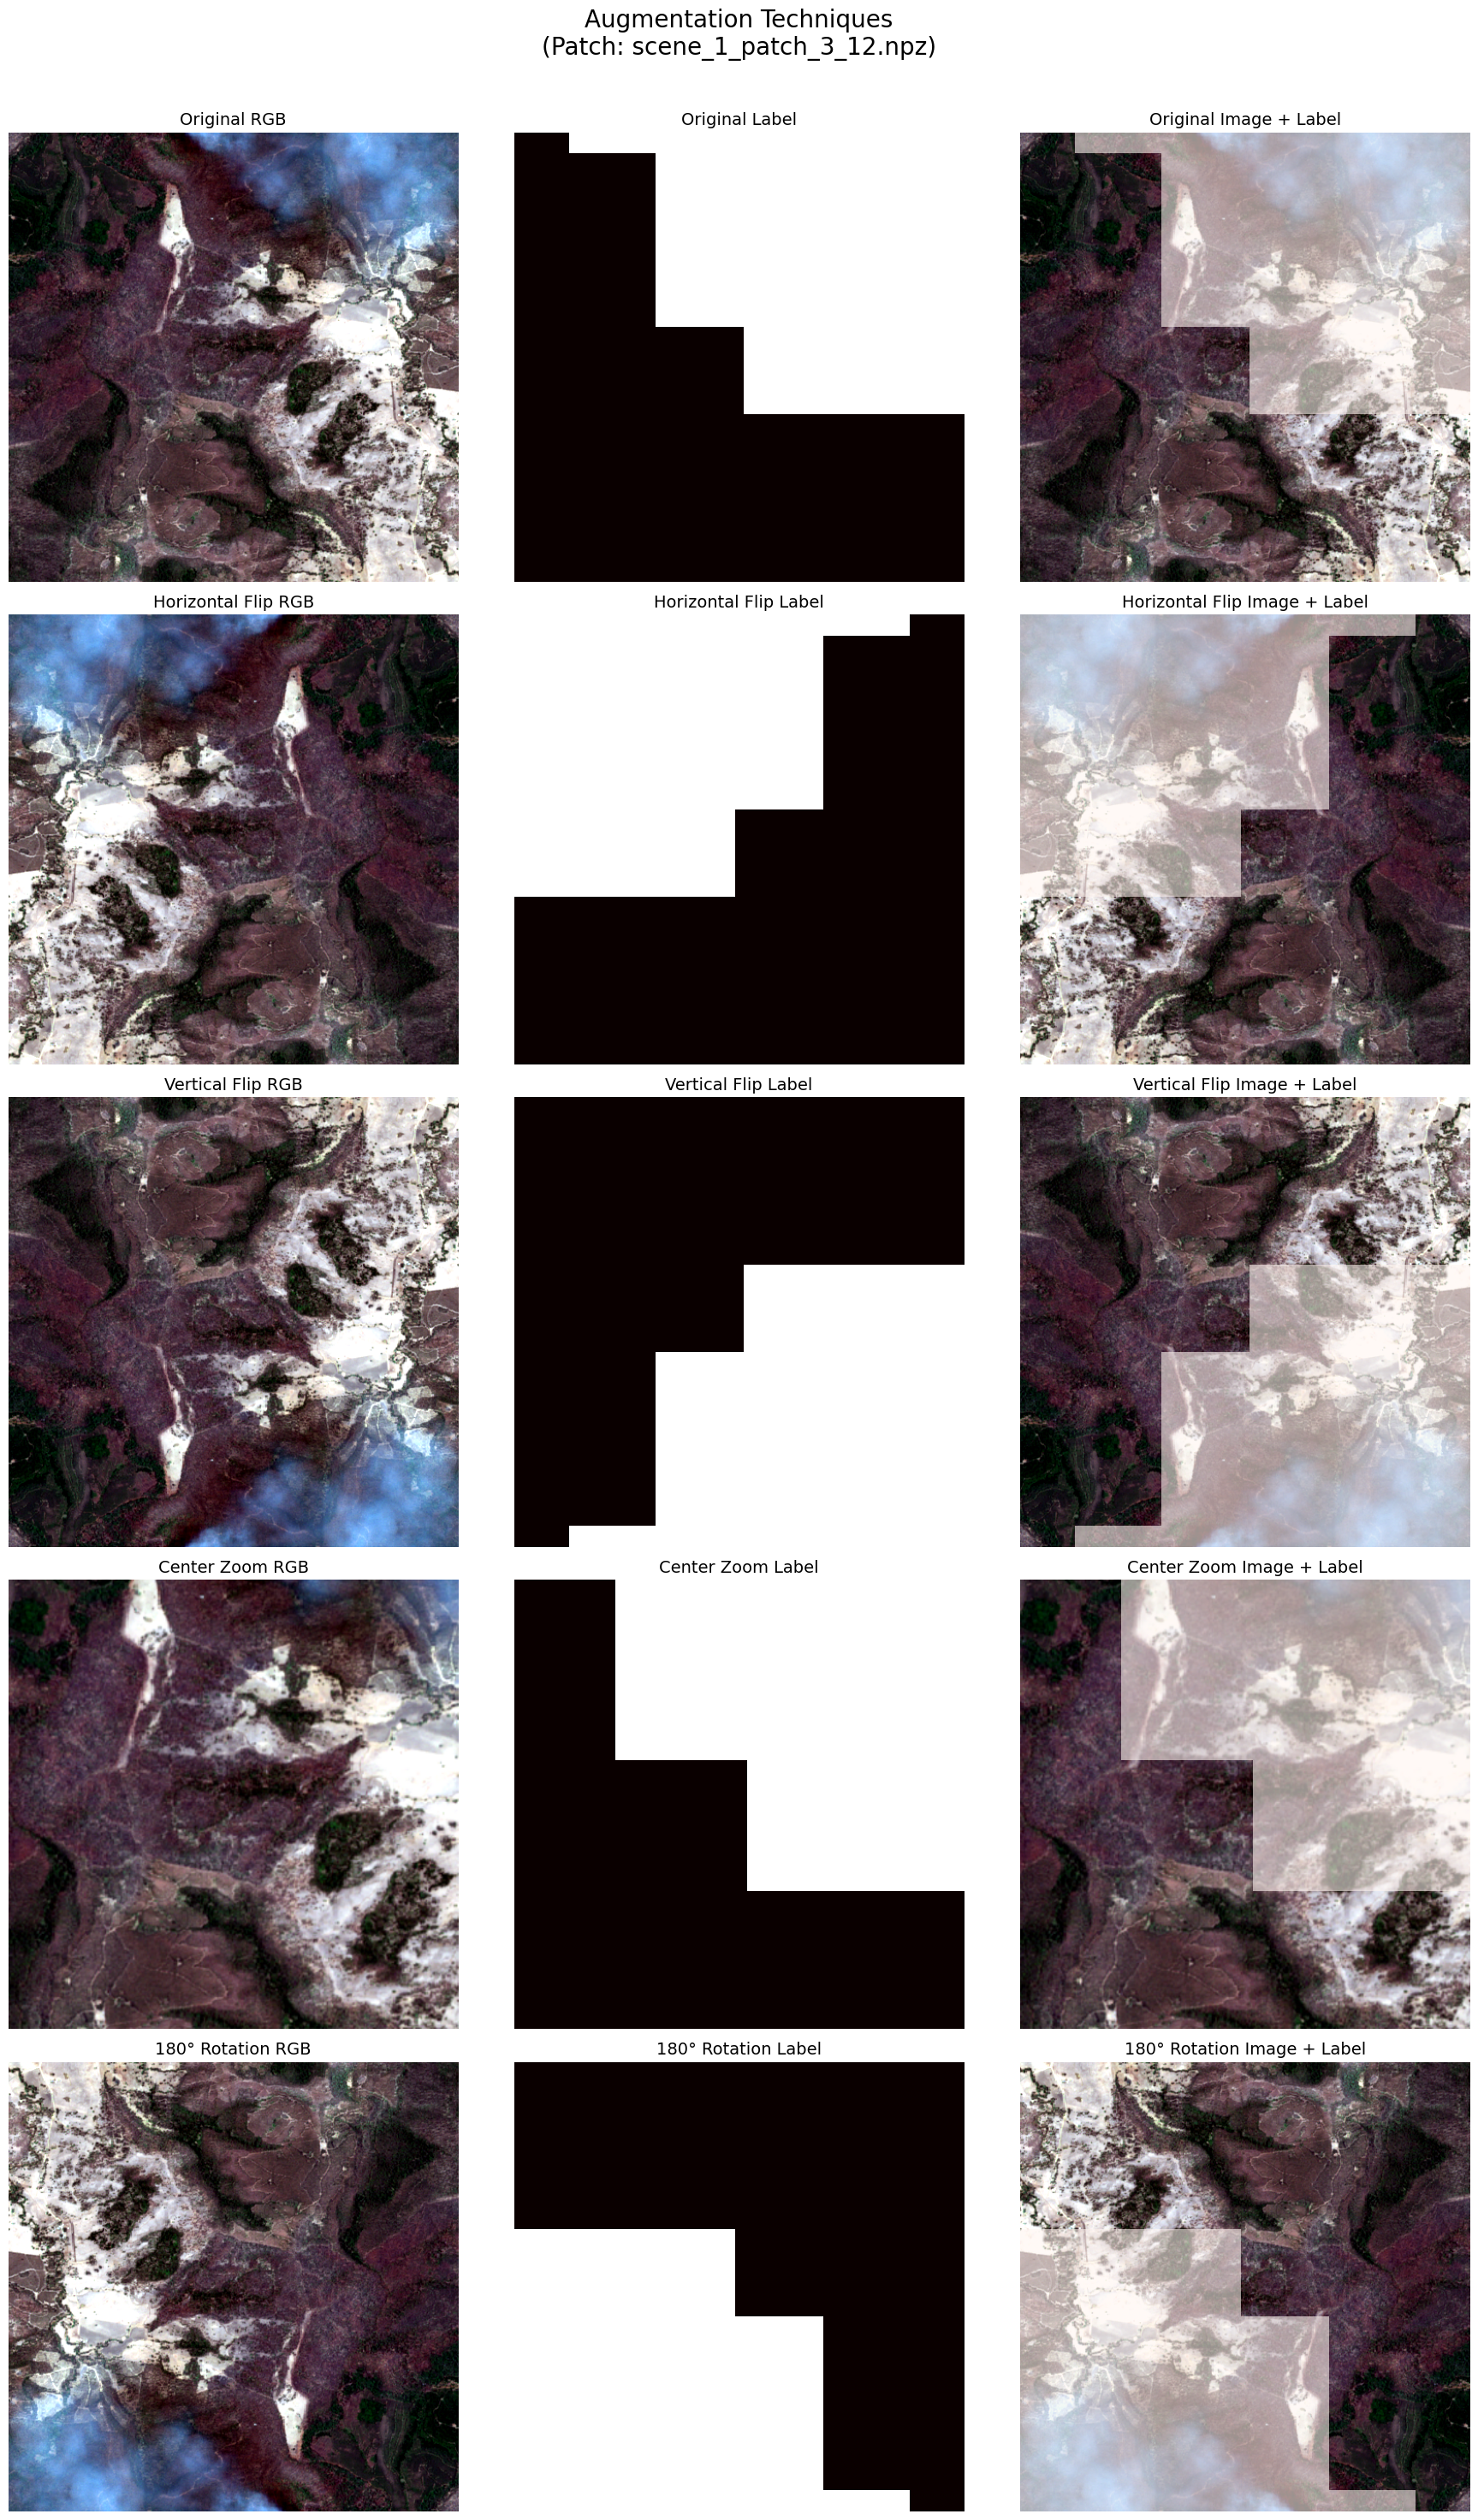

In [19]:

# --- 5. Plotting ---

# Create a helper function for plotting a row to keep the code DRY
def plot_augmentation_row(axes_row, rgb_image, label_mask, title_prefix):
    # Column 1: RGB Image
    axes_row[0].imshow(rgb_image)
    axes_row[0].set_title(f'{title_prefix} RGB', fontsize=14)
    axes_row[0].axis('off')
    
    # Column 2: Fire Label
    axes_row[1].imshow(label_mask, cmap='hot', interpolation='nearest')
    axes_row[1].set_title(f'{title_prefix} Label', fontsize=14)
    axes_row[1].axis('off')

    # Column 3: Image with Label Overlay
    masked_label = np.ma.masked_where(label_mask == 0, label_mask)
    axes_row[2].imshow(rgb_image)
    axes_row[2].imshow(masked_label, cmap='Reds', alpha=0.6, interpolation='nearest')
    axes_row[2].set_title(f'{title_prefix} Image + Label', fontsize=14)
    axes_row[2].axis('off')

# Create a 5x3 subplot grid
fig, axes = plt.subplots(5, 3, figsize=(18, 30))
fig.suptitle(f'Augmentation Techniques\n(Patch: {random_patch_name})', fontsize=20)

# Plot each row using the helper function
plot_augmentation_row(axes[0], original_rgb_display, original_label, "Original")
plot_augmentation_row(axes[1], aug_flip_x_rgb, aug_flip_x_label, "Horizontal Flip")
plot_augmentation_row(axes[2], aug_flip_y_rgb, aug_flip_y_label, "Vertical Flip")
plot_augmentation_row(axes[3], aug_zoom_rgb, aug_zoom_label, "Center Zoom")
plot_augmentation_row(axes[4], aug_flip_xy_rgb, aug_flip_xy_label, "180° Rotation")

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()